# ROTNET
Rotational Network. Predict image angles (or at least the quadrans they are in) using Convolutional Neural Network

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [21]:
transforms = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='data', train=True, download=True, transform=transforms)
test_dataset = MNIST(root='data', train=False, download=True, transform=transforms)

# Preprocess Data
Rotate the images and use the angle as labels

In [22]:
def rotate_image(image, angle):
    image = image.numpy()
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [23]:
def binarize_image(image):
    return torch.from_numpy((image > 0.5).astype(np.float32))

In [24]:
new_data = []
new_targets = []

for i in tqdm(range(len(train_dataset))):
    for angle in range(0, 360, 30):
        final_image = binarize_image(rotate_image(train_dataset.data[i], angle=angle))

        new_data.append(final_image.unsqueeze(0))
        new_targets.append(angle)

new_train_dataset = torch.utils.data.TensorDataset(torch.stack(new_data), torch.tensor(new_targets))

100%|██████████| 60000/60000 [00:47<00:00, 1270.54it/s]


In [25]:
# for i in tqdm(range(len(train_dataset))):
#     angle = np.random.randint(0, 359)
#     final_image = binarize_image(rotate_image(train_dataset.data[i], angle=angle))
#     train_dataset.data[i] = final_image
#     train_dataset.targets[i] = angle

In [26]:
for i in tqdm(range(len(test_dataset))):
    angle = random.randrange(0, 360, 30)
    final_image = binarize_image(rotate_image(test_dataset.data[i], angle=angle))
    test_dataset.data[i] = final_image
    test_dataset.targets[i] = angle

100%|██████████| 10000/10000 [00:00<00:00, 12197.94it/s]


In [27]:
loaders = {
    'train': torch.utils.data.DataLoader(new_train_dataset, batch_size=128, shuffle=False),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
}

# Modelling

Similar architecture as the mnist_pred.ipynb model

In [28]:
class RotNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        self.classificationLayer = nn.Sequential(
            nn.Linear(32 * 13 * 13, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 360),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.classificationLayer(x)
        return x

rotNet = RotNet()
rotNet

RotNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(5, 5))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(5, 5))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (classificationLayer): Sequential(
    (0): Linear(in_features=5408, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=360, bias=True)
    (4): Softmax(dim=1)
  )
)

# Training Loop

Because of the added data (rotated image on some angles), we move the model and tensors to cuda on training for a faster computation time. Return to use CPU when model is finished 

In [29]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rotNet.parameters(), lr=0.001)

In [30]:
# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rotNet.to(device)
loaders['train'] = [(data.to(device), target.to(device)) for data, target in loaders['train']]

In [31]:
num_epoch = 50
for epoch in range(num_epoch):
    running_loss = 0.0
    for i, (img, label) in enumerate(loaders['train']):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()

        output = rotNet(img)
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 128 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

[1,   128] loss: 0.368
[1,   256] loss: 0.365
[1,   384] loss: 0.363
[1,   512] loss: 0.362
[1,   640] loss: 0.359
[1,   768] loss: 0.357
[1,   896] loss: 0.356
[1,  1024] loss: 0.355
[1,  1152] loss: 0.353
[1,  1280] loss: 0.354
[1,  1408] loss: 0.356
[1,  1536] loss: 0.353
[1,  1664] loss: 0.353
[1,  1792] loss: 0.352
[1,  1920] loss: 0.353
[1,  2048] loss: 0.351
[1,  2176] loss: 0.353
[1,  2304] loss: 0.351
[1,  2432] loss: 0.350
[1,  2560] loss: 0.350
[1,  2688] loss: 0.350
[1,  2816] loss: 0.350
[1,  2944] loss: 0.350
[1,  3072] loss: 0.350
[1,  3200] loss: 0.348
[1,  3328] loss: 0.348
[1,  3456] loss: 0.349
[1,  3584] loss: 0.349
[1,  3712] loss: 0.349
[1,  3840] loss: 0.348
[1,  3968] loss: 0.348
[1,  4096] loss: 0.347
[1,  4224] loss: 0.346
[1,  4352] loss: 0.347
[1,  4480] loss: 0.347
[1,  4608] loss: 0.347
[1,  4736] loss: 0.346
[1,  4864] loss: 0.345
[1,  4992] loss: 0.345
[1,  5120] loss: 0.344
[1,  5248] loss: 0.344
[1,  5376] loss: 0.344
[1,  5504] loss: 0.342
[2,   128] 

In [32]:
rotNet.to('cpu')

RotNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(5, 5))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(5, 5))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (classificationLayer): Sequential(
    (0): Linear(in_features=5408, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=360, bias=True)
    (4): Softmax(dim=1)
  )
)

In [33]:
with torch.no_grad():
    for i, (data, actual) in enumerate(loaders['test']):
        pred = rotNet(data)
        print("Predicted: {} | Actual: {}".format(pred.argmax(dim=1), actual))

Streaming output truncated to the last 5000 lines.
Predicted: tensor([300]) | Actual: tensor([270])
Predicted: tensor([330]) | Actual: tensor([60])
Predicted: tensor([120]) | Actual: tensor([180])
Predicted: tensor([240]) | Actual: tensor([330])
Predicted: tensor([300]) | Actual: tensor([240])
Predicted: tensor([300]) | Actual: tensor([300])
Predicted: tensor([300]) | Actual: tensor([0])
Predicted: tensor([210]) | Actual: tensor([30])
Predicted: tensor([120]) | Actual: tensor([60])
Predicted: tensor([300]) | Actual: tensor([270])
Predicted: tensor([300]) | Actual: tensor([210])
Predicted: tensor([330]) | Actual: tensor([210])
Predicted: tensor([300]) | Actual: tensor([240])
Predicted: tensor([120]) | Actual: tensor([240])
Predicted: tensor([120]) | Actual: tensor([60])
Predicted: tensor([300]) | Actual: tensor([330])
Predicted: tensor([300]) | Actual: tensor([120])
Predicted: tensor([330]) | Actual: tensor([30])
Predicted: tensor([330]) | Actual: tensor([150])
Predicted: tensor([300]) 

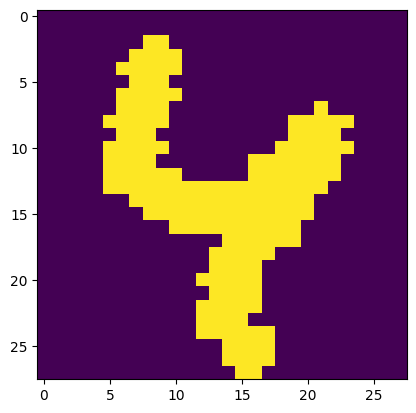

In [34]:
plt.imshow(data[0][0])